In [1]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers

Using TensorFlow backend.


In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [6]:
print(train.columns, train.shape)
print(test.columns, test.shape)
train.head()

Index(['id', 'comment_text', 'toxic', 'severe_toxic', 'obscene', 'threat',
       'insult', 'identity_hate'],
      dtype='object') (159571, 8)
Index(['id', 'comment_text'], dtype='object') (153164, 2)


,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
# check for missing data
train.isnull().any(), test.isnull().any()

(id               False
 comment_text     False
 toxic            False
 severe_toxic     False
 obscene          False
 threat           False
 insult           False
 identity_hate    False
 dtype: bool, id              False
 comment_text    False
 dtype: bool)

In [13]:
tag_cols = train.columns[2:]
y = train[tag_cols].values # extract numpy arrays
list_sent_train = train['comment_text']
list_sent_test  = test['comment_text']


In [14]:
# prepare to feed into LSTM, with keras modules 
max_features = 20000
tokenizer = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(list(list_sent_train))

In [15]:
list_tokenized_train = tokenizer.texts_to_sequences(list_sent_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sent_test)

In [21]:
# list_tokenized_train[:1] # sequences of index

(array([31008., 26747., 20290., 14356., 11148.,  8678.,  6635.,  5132.,
         3985.,  3308.,  2718.,  2271.,  1821.,  1560.,  1242.,  1177.,
          982.,   964.,   730.,   692.,   642.,   583.,   458.,   488.,
          356.,   340.,   272.,   259.,   278.,   204.,   213.,   178.,
          169.,   159.,   161.,   128.,   123.,   122.,    95.,    96.,
           87.,   100.,    71.,    87.,    73.,    66.,    58.,    67.,
           65.]),
 array([  0,  10,  20,  30,  40,  50,  60,  70,  80,  90, 100, 110, 120,
        130, 140, 150, 160, 170, 180, 190, 200, 210, 220, 230, 240, 250,
        260, 270, 280, 290, 300, 310, 320, 330, 340, 350, 360, 370, 380,
        390, 400, 410, 420, 430, 440, 450, 460, 470, 480, 490]),
 <a list of 49 Patch objects>)

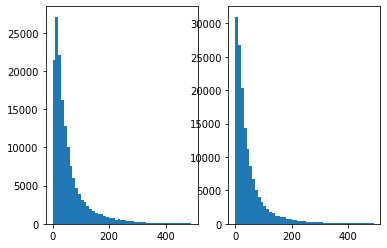

In [26]:
# padding
# check total number of words in each comment
word_count_train = [len(c) for c in list_tokenized_train]
word_count_test = [len(c) for c in list_tokenized_test]
plt.subplot(121)
plt.hist(word_count_train, bins = np.arange(0,500, 10))
plt.subplot(122)
plt.hist(word_count_test, bins = np.arange(0,500, 10))

In [27]:
maxlen = 200
X_train = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_test = pad_sequences(list_tokenized_test, maxlen=maxlen)

### Building LSTM models

In [30]:
inp = Input(shape = (maxlen,))
embed_size = 128
x = Embedding(max_features, embed_size)(inp)

Instructions for updating:
Colocations handled automatically by placer.


In [31]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

x = GlobalMaxPool1D()(x)

x = Dropout(0.1)(x)

x = Dense(50, activation="relu")(x)

x = Dropout(0.1)(x)

x = Dense(6, activation  = "sigmoid")(x)

In [37]:
model = Model(inputs=inp, outputs=x)
model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])

In [40]:
batch_size = 32
epochs = 3
model.fit(X_train,y, batch_size=batch_size, epochs=epochs, 
          validation_split=0.1)
# accuracy not bad

Train on 143613 samples, validate on 15958 samples
Epoch 1/3
143613/143613 [==============================] - 1317s 9ms/step - loss: 0.0657 - accuracy: 0.9784 - val_loss: 0.0485 - val_accuracy: 0.9821
Epoch 2/3
143613/143613 [==============================] - 9378s 65ms/step - loss: 0.0440 - accuracy: 0.9833 - val_loss: 0.0477 - val_accuracy: 0.9822
Epoch 3/3
143613/143613 [==============================] - 1330s 9ms/step - loss: 0.0385 - accuracy: 0.9849 - val_loss: 0.0462 - val_accuracy: 0.9827


In [44]:
y_pred = model.predict(X_test, batch_size=batch_size, verbose=1)

153164/153164 [==============================] - ETA:  - 322s 2ms/step


In [71]:
pred = pd.concat([test['id'],pd.DataFrame(y_pred > 0.5, columns = tag_cols).astype('int32').apply(lambda x:-x)], axis = 1)

In [72]:
pred.to_csv('sub1.csv', index=False)